# Image Understanding Final Project - Implementing GANS

In [1]:
import utils, torch, time, os, pickle
from matplotlib import pyplot as plt
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,models, transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'# !pip install torchsummary 
from keras.datasets import fashion_mnist


Using TensorFlow backend.


# Loading the Training and Testing Data using Data Loader with Data Augmentation



In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
batch_size=100
z_dim = 64
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('Tshirt', 'Trouser', 'PullOver', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'BAg', 'Ankle Boot')


# Showing the Input Data 
* Dint use Pytorch to show data as, I already had code written using numpy

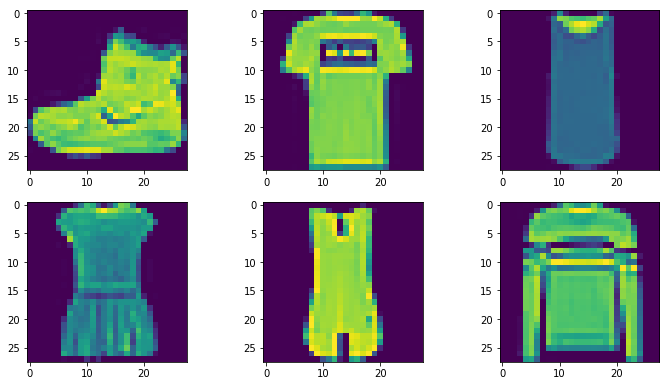

In [3]:
# Preview the training data
plt.figure(figsize=(12,10))# Showing the Input Data after Normalizing
x, y = 3, 3
for i in range(6):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i],interpolation='nearest')
plt.show()

## Defining Convolution Neural Network
* Initially I tried using 2 and 3 layer convolutions with dropout(0.5) and batchregularization, but the accuracy varied between 69 - (75, 77 ) percent. Later on I shifted to VGG networks which gave better accuracy. 
* After Implementing different VGG Networks, VGG13 gave the best results. 



In [4]:
class generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

class discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x
    
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [5]:
G_net = generator(input_dim=z_dim)
D_net = discriminator()
G_net.to(device)
D_net.to(device)
if device == 'cuda':
    G_net = torch.nn.DataParallel(G_net)
    D_net = torch.nn.DataParallel(D_net)
torch.backends.cudnn.benchmark = True

In [6]:
G_net
D_net

DataParallel(
  (module): discriminator(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2)
    )
    (fc): Sequential(
      (0): Linear(in_features=8192, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Linear(in_features=1024, out_features=1, bias=True)
      (4): Sigmoid()
    )
  )
)

In [7]:
G_optimizer = optim.Adam(G_net.parameters(), lr=0.0002, betas=(0.5, 0.999), eps=1e-08, weight_decay= 5e-4)
D_optimizer = optim.Adam(D_net.parameters(), lr=0.0002, betas=(0.5, 0.999), eps=1e-08, weight_decay= 5e-4)
criterion =  nn.BCELoss()


In [8]:
y_real_, y_fake_ = torch.ones(batch_size, 1), torch.zeros(batch_size, 1)
if device == 'cuda':
    y_real_,y_fake_ = y_real_.to(device), y_fake_.to(device)
# fixed noise
sample_z_ = torch.rand((batch_size, z_dim))

In [9]:
# sample_z_.shape

In [10]:
train_hist = {}
train_hist['D_loss'] = []
train_hist['G_loss'] = []
train_hist['per_epoch_time'] = []
train_hist['total_time'] = []
epochs = 400
img = []

## Training

In [11]:
def train():
    D_net.train()
    print('training start!!')
    start_time = time.time()
    for epoch in range(epochs):
        G_net.train()
        epoch_start_time = time.time()
#     print(criterion)
#     training_loss = 0
#     train_correct = 0
#     lo = []
        for batch_idx, (data, target) in enumerate(train_loader):
        
            #==== Updating Discriminative Network=====#

            #==== Making Random Noise=====#
            z_ = torch.rand((batch_size, z_dim))
            data, target, z_ = data.to(device), target.to(device), z_.to(device)

            D_optimizer.zero_grad()

            #==== Forward Pass for Discriminator=====
            D_real = D_net(data)
            D_real_loss = criterion(D_real, y_real_)

            #==== Forward Pass for Generative=====
            G_ = G_net(z_)
            D_fake = D_net(G_)
            D_fake_loss = criterion(D_fake, y_fake_)

            #==== Total Loss=====
            D_loss = D_real_loss + D_fake_loss
            train_hist['D_loss'].append(D_loss.item())

            #=====Backward Pass=======
            D_loss.backward()
            D_optimizer.step()

            #==== Updating Generative Network=====#

            G_optimizer.zero_grad()        
             #==== Forward Pass for Generative=====
            G_ = G_net(z_)
            D_fake = D_net(G_)

            #==== Total Loss=====
            G_loss = criterion(D_fake, y_real_)
            train_hist['G_loss'].append(G_loss.item())
            #=====Backward Pass=======
            G_loss.backward()
            G_optimizer.step()

            if ((batch_idx + 1) % 100) == 0:
                print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
    ((epoch + 1), (batch_idx + 1), train_loader.dataset.__len__() // batch_size, D_loss.item(), G_loss.item()))

        train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
        with torch.no_grad():
            visualize_results()
            
    train_hist['total_time'].append(time.time() - start_time)
    print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(train_hist['per_epoch_time']),
              epoch, train_hist['total_time'][0]))
    print("Training finish!... save training results")
    save()

def save():
    save_dir = "./models/"
    torch.save(G_net.state_dict(), os.path.join(save_dir,  '_G.pkl'))
    torch.save(D_net.state_dict(), os.path.join(save_dir,'_D.pkl'))
    np.save('./models/train_hist.npy', train_hist)
    np.save('./models/img.npy', img)
    
    
    with open(os.path.join(save_dir, '_history.pkl'), 'wb') as f:
        pickle.dump(train_hist, f)
        
    with open(os.path.join(save_dir, '_img.pkl'), 'wb') as g:
        pickle.dump(img, g)
        
def load():
    save_dir = "./models/"
    G_net.load_state_dict(torch.load(os.path.join(save_dir, '_G.pkl')))
    D_net.load_state_dict(torch.load(os.path.join(save_dir, '_D.pkl')))
    train_hist = np.load('./models/train_hist.npy')
    img = np.load('./models/img.npy')
#     with open(os.path.join(save_dir, '_history.pkl'), 'rb') as f:
#         train_hist = pickle.load(f)
#     with open(os.path.join(save_dir, '_img.pkl'), 'rb') as g:
#         img = pickle.load(g)
        
def visualize_results(fix=True):
    G_net.eval()
#     sample_z_ = torch.rand((batch_size, z_dim))
    result_dir = "./results/"
#     print(sample_z_.shape)
    if fix:
        """ fixed noise """
        samples = G_net(sample_z_)
    else:
        """ random noise """
        sample_z = torch.rand((batch_size,z_dim))
        sample_z = sample_z.cuda()
        samples = G_net(sample_z)
    samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
    img.append(samples)
        

In [12]:
# load()
# visualize_results()
# train_hist

In [13]:
train()

training start!!
Epoch: [ 1] [ 100/ 600] D_loss: 1.14739239, G_loss: 0.92504001
Epoch: [ 1] [ 200/ 600] D_loss: 0.99153078, G_loss: 1.11182642
Epoch: [ 1] [ 300/ 600] D_loss: 0.93771935, G_loss: 1.03991544
Epoch: [ 1] [ 400/ 600] D_loss: 0.94720232, G_loss: 1.11375403
Epoch: [ 1] [ 500/ 600] D_loss: 1.01309848, G_loss: 0.98986465
Epoch: [ 1] [ 600/ 600] D_loss: 0.89304543, G_loss: 1.19670761
Epoch: [ 2] [ 100/ 600] D_loss: 1.01434159, G_loss: 1.12832654
Epoch: [ 2] [ 200/ 600] D_loss: 0.87536502, G_loss: 1.29696453
Epoch: [ 2] [ 300/ 600] D_loss: 0.99815768, G_loss: 1.08829463
Epoch: [ 2] [ 400/ 600] D_loss: 0.90035611, G_loss: 1.23344922
Epoch: [ 2] [ 500/ 600] D_loss: 1.04030931, G_loss: 1.30579972
Epoch: [ 2] [ 600/ 600] D_loss: 1.08866906, G_loss: 1.01912487
Epoch: [ 3] [ 100/ 600] D_loss: 1.02602768, G_loss: 1.20486569
Epoch: [ 3] [ 200/ 600] D_loss: 1.16556382, G_loss: 1.18915951
Epoch: [ 3] [ 300/ 600] D_loss: 0.97898895, G_loss: 1.15618205
Epoch: [ 3] [ 400/ 600] D_loss: 1.0041

Epoch: [22] [ 500/ 600] D_loss: 0.74588430, G_loss: 1.93424058
Epoch: [22] [ 600/ 600] D_loss: 0.72098899, G_loss: 2.03211045
Epoch: [23] [ 100/ 600] D_loss: 0.87479591, G_loss: 1.84495127
Epoch: [23] [ 200/ 600] D_loss: 0.83830273, G_loss: 1.70274842
Epoch: [23] [ 300/ 600] D_loss: 0.72033226, G_loss: 1.73759854
Epoch: [23] [ 400/ 600] D_loss: 0.81696743, G_loss: 1.90592301
Epoch: [23] [ 500/ 600] D_loss: 0.86963260, G_loss: 2.01246977
Epoch: [23] [ 600/ 600] D_loss: 0.68984079, G_loss: 1.67516780
Epoch: [24] [ 100/ 600] D_loss: 0.86539054, G_loss: 1.59594440
Epoch: [24] [ 200/ 600] D_loss: 0.73212183, G_loss: 1.97285306
Epoch: [24] [ 300/ 600] D_loss: 0.77542025, G_loss: 1.88146389
Epoch: [24] [ 400/ 600] D_loss: 0.71202326, G_loss: 1.81753588
Epoch: [24] [ 500/ 600] D_loss: 0.84684604, G_loss: 2.01592374
Epoch: [24] [ 600/ 600] D_loss: 0.80849272, G_loss: 1.66424942
Epoch: [25] [ 100/ 600] D_loss: 0.57879031, G_loss: 1.98053515
Epoch: [25] [ 200/ 600] D_loss: 0.74596876, G_loss: 1.8

Epoch: [44] [ 400/ 600] D_loss: 0.63491559, G_loss: 2.73753119
Epoch: [44] [ 500/ 600] D_loss: 0.55676681, G_loss: 2.00460815
Epoch: [44] [ 600/ 600] D_loss: 0.53931898, G_loss: 2.15055919
Epoch: [45] [ 100/ 600] D_loss: 0.78039968, G_loss: 2.66579342
Epoch: [45] [ 200/ 600] D_loss: 1.06714737, G_loss: 2.78499246
Epoch: [45] [ 300/ 600] D_loss: 0.57528305, G_loss: 2.26213908
Epoch: [45] [ 400/ 600] D_loss: 0.64095390, G_loss: 2.33447814
Epoch: [45] [ 500/ 600] D_loss: 0.56360936, G_loss: 2.17056298
Epoch: [45] [ 600/ 600] D_loss: 0.81473017, G_loss: 2.27402806
Epoch: [46] [ 100/ 600] D_loss: 0.67014039, G_loss: 1.60873413
Epoch: [46] [ 200/ 600] D_loss: 0.55076802, G_loss: 2.25360394
Epoch: [46] [ 300/ 600] D_loss: 0.79603863, G_loss: 1.40669942
Epoch: [46] [ 400/ 600] D_loss: 0.53641599, G_loss: 2.29340625
Epoch: [46] [ 500/ 600] D_loss: 0.56324863, G_loss: 2.51880670
Epoch: [46] [ 600/ 600] D_loss: 0.76801610, G_loss: 1.75036013
Epoch: [47] [ 100/ 600] D_loss: 0.53877687, G_loss: 2.1

Epoch: [66] [ 300/ 600] D_loss: 0.97913110, G_loss: 0.99033678
Epoch: [66] [ 400/ 600] D_loss: 0.48074305, G_loss: 2.61518788
Epoch: [66] [ 500/ 600] D_loss: 0.49222055, G_loss: 2.33667493
Epoch: [66] [ 600/ 600] D_loss: 0.38825715, G_loss: 1.97400951
Epoch: [67] [ 100/ 600] D_loss: 0.46198237, G_loss: 2.37554741
Epoch: [67] [ 200/ 600] D_loss: 0.47534460, G_loss: 2.70544004
Epoch: [67] [ 300/ 600] D_loss: 0.56438309, G_loss: 2.47595453
Epoch: [67] [ 400/ 600] D_loss: 0.48247740, G_loss: 2.49861217
Epoch: [67] [ 500/ 600] D_loss: 0.40875596, G_loss: 2.95410395
Epoch: [67] [ 600/ 600] D_loss: 0.58151925, G_loss: 2.12456870
Epoch: [68] [ 100/ 600] D_loss: 0.51893038, G_loss: 2.55192924
Epoch: [68] [ 200/ 600] D_loss: 0.55140972, G_loss: 2.57524943
Epoch: [68] [ 300/ 600] D_loss: 0.55926579, G_loss: 2.66465211
Epoch: [68] [ 400/ 600] D_loss: 0.43821663, G_loss: 2.97905588
Epoch: [68] [ 500/ 600] D_loss: 0.60168266, G_loss: 1.96647477
Epoch: [68] [ 600/ 600] D_loss: 0.42059219, G_loss: 2.5

Epoch: [88] [ 200/ 600] D_loss: 0.40398350, G_loss: 3.03423977
Epoch: [88] [ 300/ 600] D_loss: 0.59206849, G_loss: 2.65112305
Epoch: [88] [ 400/ 600] D_loss: 0.32255334, G_loss: 3.21619654
Epoch: [88] [ 500/ 600] D_loss: 0.41001359, G_loss: 3.20428538
Epoch: [88] [ 600/ 600] D_loss: 0.56850511, G_loss: 2.18826818
Epoch: [89] [ 100/ 600] D_loss: 0.40448299, G_loss: 3.08538842
Epoch: [89] [ 200/ 600] D_loss: 0.34013703, G_loss: 2.95714664
Epoch: [89] [ 300/ 600] D_loss: 0.36479115, G_loss: 2.81150246
Epoch: [89] [ 400/ 600] D_loss: 0.59251541, G_loss: 3.60359716
Epoch: [89] [ 500/ 600] D_loss: 0.48476577, G_loss: 2.90178990
Epoch: [89] [ 600/ 600] D_loss: 0.47374883, G_loss: 3.06540465
Epoch: [90] [ 100/ 600] D_loss: 0.34701955, G_loss: 3.29694033
Epoch: [90] [ 200/ 600] D_loss: 0.50330383, G_loss: 1.94670391
Epoch: [90] [ 300/ 600] D_loss: 0.37245518, G_loss: 2.80254984
Epoch: [90] [ 400/ 600] D_loss: 0.50172436, G_loss: 2.43180227
Epoch: [90] [ 500/ 600] D_loss: 0.38429081, G_loss: 3.5

Epoch: [109] [ 600/ 600] D_loss: 0.47487646, G_loss: 3.45284915
Epoch: [110] [ 100/ 600] D_loss: 0.51365942, G_loss: 1.91588545
Epoch: [110] [ 200/ 600] D_loss: 0.43648982, G_loss: 3.06457853
Epoch: [110] [ 300/ 600] D_loss: 0.34593162, G_loss: 3.61907315
Epoch: [110] [ 400/ 600] D_loss: 0.33150524, G_loss: 3.32966518
Epoch: [110] [ 500/ 600] D_loss: 0.38997144, G_loss: 3.45595622
Epoch: [110] [ 600/ 600] D_loss: 0.36151776, G_loss: 3.05658960
Epoch: [111] [ 100/ 600] D_loss: 0.62585318, G_loss: 1.75927496
Epoch: [111] [ 200/ 600] D_loss: 0.36191261, G_loss: 3.44303894
Epoch: [111] [ 300/ 600] D_loss: 0.52412325, G_loss: 2.65136051
Epoch: [111] [ 400/ 600] D_loss: 0.36670625, G_loss: 3.00565743
Epoch: [111] [ 500/ 600] D_loss: 0.38787508, G_loss: 2.31017447
Epoch: [111] [ 600/ 600] D_loss: 0.40248623, G_loss: 3.05083871
Epoch: [112] [ 100/ 600] D_loss: 0.50323236, G_loss: 3.09409118
Epoch: [112] [ 200/ 600] D_loss: 0.45137683, G_loss: 3.21476984
Epoch: [112] [ 300/ 600] D_loss: 0.69512

Epoch: [131] [ 300/ 600] D_loss: 0.43072617, G_loss: 2.48758411
Epoch: [131] [ 400/ 600] D_loss: 0.42599726, G_loss: 2.81647158
Epoch: [131] [ 500/ 600] D_loss: 0.43739939, G_loss: 2.73791718
Epoch: [131] [ 600/ 600] D_loss: 0.37478200, G_loss: 3.56104732
Epoch: [132] [ 100/ 600] D_loss: 0.44837624, G_loss: 3.27732754
Epoch: [132] [ 200/ 600] D_loss: 0.30383015, G_loss: 2.90501809
Epoch: [132] [ 300/ 600] D_loss: 0.38986033, G_loss: 3.28096151
Epoch: [132] [ 400/ 600] D_loss: 0.40752926, G_loss: 3.21695924
Epoch: [132] [ 500/ 600] D_loss: 0.41252148, G_loss: 3.55846000
Epoch: [132] [ 600/ 600] D_loss: 0.35311162, G_loss: 3.80181861
Epoch: [133] [ 100/ 600] D_loss: 0.46550837, G_loss: 3.03676319
Epoch: [133] [ 200/ 600] D_loss: 0.30170804, G_loss: 3.15271688
Epoch: [133] [ 300/ 600] D_loss: 0.23593187, G_loss: 3.26320839
Epoch: [133] [ 400/ 600] D_loss: 0.28381172, G_loss: 3.15857267
Epoch: [133] [ 500/ 600] D_loss: 0.48790765, G_loss: 3.75762844
Epoch: [133] [ 600/ 600] D_loss: 0.64926

Epoch: [152] [ 600/ 600] D_loss: 0.37854990, G_loss: 2.85020900
Epoch: [153] [ 100/ 600] D_loss: 0.31783646, G_loss: 3.61225820
Epoch: [153] [ 200/ 600] D_loss: 0.45270762, G_loss: 3.70244956
Epoch: [153] [ 300/ 600] D_loss: 0.39721859, G_loss: 2.48387766
Epoch: [153] [ 400/ 600] D_loss: 0.31115049, G_loss: 3.50712466
Epoch: [153] [ 500/ 600] D_loss: 0.93949318, G_loss: 4.53701258
Epoch: [153] [ 600/ 600] D_loss: 0.43259758, G_loss: 2.69395852
Epoch: [154] [ 100/ 600] D_loss: 0.42177889, G_loss: 3.22202730
Epoch: [154] [ 200/ 600] D_loss: 0.25458604, G_loss: 3.18950009
Epoch: [154] [ 300/ 600] D_loss: 0.56056577, G_loss: 3.25849485
Epoch: [154] [ 400/ 600] D_loss: 0.36578253, G_loss: 2.81258488
Epoch: [154] [ 500/ 600] D_loss: 0.38170549, G_loss: 2.53917289
Epoch: [154] [ 600/ 600] D_loss: 0.38275778, G_loss: 3.68296671
Epoch: [155] [ 100/ 600] D_loss: 0.55610698, G_loss: 2.65842128
Epoch: [155] [ 200/ 600] D_loss: 0.48345402, G_loss: 2.79094815
Epoch: [155] [ 300/ 600] D_loss: 0.31905

Epoch: [174] [ 300/ 600] D_loss: 0.34323508, G_loss: 2.80413389
Epoch: [174] [ 400/ 600] D_loss: 0.31407291, G_loss: 3.28834176
Epoch: [174] [ 500/ 600] D_loss: 0.52136266, G_loss: 2.65482116
Epoch: [174] [ 600/ 600] D_loss: 0.37511569, G_loss: 4.32395649
Epoch: [175] [ 100/ 600] D_loss: 0.45729977, G_loss: 2.48576665
Epoch: [175] [ 200/ 600] D_loss: 0.37937671, G_loss: 3.03951144
Epoch: [175] [ 300/ 600] D_loss: 0.44909513, G_loss: 3.27684975
Epoch: [175] [ 400/ 600] D_loss: 0.47155869, G_loss: 2.99756432
Epoch: [175] [ 500/ 600] D_loss: 0.31716889, G_loss: 3.25491428
Epoch: [175] [ 600/ 600] D_loss: 0.40720800, G_loss: 2.82684803
Epoch: [176] [ 100/ 600] D_loss: 0.48197913, G_loss: 2.63249326
Epoch: [176] [ 200/ 600] D_loss: 0.76763302, G_loss: 1.79875028
Epoch: [176] [ 300/ 600] D_loss: 0.51814198, G_loss: 4.15074587
Epoch: [176] [ 400/ 600] D_loss: 0.42140362, G_loss: 2.96450353
Epoch: [176] [ 500/ 600] D_loss: 0.68784231, G_loss: 2.42152190
Epoch: [176] [ 600/ 600] D_loss: 0.41380

Epoch: [195] [ 600/ 600] D_loss: 0.37104976, G_loss: 2.82898045
Epoch: [196] [ 100/ 600] D_loss: 0.36495146, G_loss: 3.27014399
Epoch: [196] [ 200/ 600] D_loss: 0.64161491, G_loss: 3.08550620
Epoch: [196] [ 300/ 600] D_loss: 0.46329719, G_loss: 3.83251476
Epoch: [196] [ 400/ 600] D_loss: 0.42015404, G_loss: 3.41304493
Epoch: [196] [ 500/ 600] D_loss: 0.52240455, G_loss: 2.53756189
Epoch: [196] [ 600/ 600] D_loss: 0.30047816, G_loss: 3.28286886
Epoch: [197] [ 100/ 600] D_loss: 0.43221319, G_loss: 3.62408876
Epoch: [197] [ 200/ 600] D_loss: 0.88100517, G_loss: 4.08397675
Epoch: [197] [ 300/ 600] D_loss: 0.46331739, G_loss: 2.64474583
Epoch: [197] [ 400/ 600] D_loss: 0.32574368, G_loss: 2.95639277
Epoch: [197] [ 500/ 600] D_loss: 0.52616155, G_loss: 3.78722787
Epoch: [197] [ 600/ 600] D_loss: 0.43165782, G_loss: 2.29728222
Epoch: [198] [ 100/ 600] D_loss: 0.35033876, G_loss: 3.40910101
Epoch: [198] [ 200/ 600] D_loss: 0.31165245, G_loss: 3.22457957
Epoch: [198] [ 300/ 600] D_loss: 0.33942

Epoch: [217] [ 300/ 600] D_loss: 0.47527450, G_loss: 2.58351970
Epoch: [217] [ 400/ 600] D_loss: 0.29317930, G_loss: 3.30083990
Epoch: [217] [ 500/ 600] D_loss: 0.37647989, G_loss: 3.32657909
Epoch: [217] [ 600/ 600] D_loss: 0.39106196, G_loss: 2.59934473
Epoch: [218] [ 100/ 600] D_loss: 0.26446825, G_loss: 3.87967038
Epoch: [218] [ 200/ 600] D_loss: 0.36626899, G_loss: 3.00020576
Epoch: [218] [ 300/ 600] D_loss: 0.57757413, G_loss: 1.75623369
Epoch: [218] [ 400/ 600] D_loss: 0.31321922, G_loss: 2.89571524
Epoch: [218] [ 500/ 600] D_loss: 0.38582236, G_loss: 2.21658635
Epoch: [218] [ 600/ 600] D_loss: 0.37575182, G_loss: 3.92284107
Epoch: [219] [ 100/ 600] D_loss: 0.42590544, G_loss: 3.62320852
Epoch: [219] [ 200/ 600] D_loss: 0.27519777, G_loss: 2.82375240
Epoch: [219] [ 300/ 600] D_loss: 0.33656996, G_loss: 3.09974241
Epoch: [219] [ 400/ 600] D_loss: 0.30956724, G_loss: 3.57772160
Epoch: [219] [ 500/ 600] D_loss: 0.64218986, G_loss: 2.18556237
Epoch: [219] [ 600/ 600] D_loss: 0.46691

Epoch: [238] [ 600/ 600] D_loss: 0.32365572, G_loss: 3.43151832
Epoch: [239] [ 100/ 600] D_loss: 0.40341595, G_loss: 2.63083744
Epoch: [239] [ 200/ 600] D_loss: 0.40789980, G_loss: 3.85674143
Epoch: [239] [ 300/ 600] D_loss: 0.35022289, G_loss: 3.19644403
Epoch: [239] [ 400/ 600] D_loss: 0.49358195, G_loss: 2.52578974
Epoch: [239] [ 500/ 600] D_loss: 0.23317030, G_loss: 3.04575372
Epoch: [239] [ 600/ 600] D_loss: 0.39364380, G_loss: 3.71935081
Epoch: [240] [ 100/ 600] D_loss: 0.29899395, G_loss: 3.54854250
Epoch: [240] [ 200/ 600] D_loss: 0.39053524, G_loss: 3.43966603
Epoch: [240] [ 300/ 600] D_loss: 0.31141102, G_loss: 2.15889835
Epoch: [240] [ 400/ 600] D_loss: 0.43373120, G_loss: 2.83955407
Epoch: [240] [ 500/ 600] D_loss: 0.38765714, G_loss: 3.91408062
Epoch: [240] [ 600/ 600] D_loss: 0.45298287, G_loss: 2.85511041
Epoch: [241] [ 100/ 600] D_loss: 0.40107054, G_loss: 3.20162201
Epoch: [241] [ 200/ 600] D_loss: 0.43319935, G_loss: 2.35323358
Epoch: [241] [ 300/ 600] D_loss: 0.79160

Epoch: [260] [ 300/ 600] D_loss: 0.52884430, G_loss: 3.25106812
Epoch: [260] [ 400/ 600] D_loss: 0.28251576, G_loss: 3.40579104
Epoch: [260] [ 500/ 600] D_loss: 0.39517558, G_loss: 2.38151288
Epoch: [260] [ 600/ 600] D_loss: 0.33943039, G_loss: 3.36436248
Epoch: [261] [ 100/ 600] D_loss: 0.32256466, G_loss: 4.00729990
Epoch: [261] [ 200/ 600] D_loss: 0.48612082, G_loss: 3.20717192
Epoch: [261] [ 300/ 600] D_loss: 0.38969019, G_loss: 3.18660092
Epoch: [261] [ 400/ 600] D_loss: 0.44481415, G_loss: 2.68582368
Epoch: [261] [ 500/ 600] D_loss: 0.46302995, G_loss: 2.56858373
Epoch: [261] [ 600/ 600] D_loss: 0.27118814, G_loss: 3.45044994
Epoch: [262] [ 100/ 600] D_loss: 0.33287829, G_loss: 2.99009585
Epoch: [262] [ 200/ 600] D_loss: 0.33569509, G_loss: 3.84041691
Epoch: [262] [ 300/ 600] D_loss: 0.36313236, G_loss: 3.26576447
Epoch: [262] [ 400/ 600] D_loss: 0.38876608, G_loss: 2.98949742
Epoch: [262] [ 500/ 600] D_loss: 0.35624462, G_loss: 3.36575961
Epoch: [262] [ 600/ 600] D_loss: 0.41746

Epoch: [281] [ 600/ 600] D_loss: 0.45643151, G_loss: 3.62376118
Epoch: [282] [ 100/ 600] D_loss: 0.49030620, G_loss: 4.23447132
Epoch: [282] [ 200/ 600] D_loss: 0.45356452, G_loss: 3.12340307
Epoch: [282] [ 300/ 600] D_loss: 0.42867452, G_loss: 3.71189547
Epoch: [282] [ 400/ 600] D_loss: 0.28896958, G_loss: 3.33596230
Epoch: [282] [ 500/ 600] D_loss: 0.59215868, G_loss: 2.58951139
Epoch: [282] [ 600/ 600] D_loss: 0.30265540, G_loss: 3.53534412
Epoch: [283] [ 100/ 600] D_loss: 0.50527740, G_loss: 2.02815390
Epoch: [283] [ 200/ 600] D_loss: 0.45599464, G_loss: 3.22405577
Epoch: [283] [ 300/ 600] D_loss: 0.27567217, G_loss: 3.52249289
Epoch: [283] [ 400/ 600] D_loss: 0.42711955, G_loss: 2.56792045
Epoch: [283] [ 500/ 600] D_loss: 0.47552568, G_loss: 2.85123420
Epoch: [283] [ 600/ 600] D_loss: 0.36440802, G_loss: 3.75662303
Epoch: [284] [ 100/ 600] D_loss: 0.32117584, G_loss: 3.69604182
Epoch: [284] [ 200/ 600] D_loss: 0.51381290, G_loss: 2.59565830
Epoch: [284] [ 300/ 600] D_loss: 0.38546

Epoch: [303] [ 300/ 600] D_loss: 0.37941015, G_loss: 2.90436101
Epoch: [303] [ 400/ 600] D_loss: 0.33392808, G_loss: 3.33783698
Epoch: [303] [ 500/ 600] D_loss: 0.58225578, G_loss: 1.91678083
Epoch: [303] [ 600/ 600] D_loss: 0.37333667, G_loss: 3.39410090
Epoch: [304] [ 100/ 600] D_loss: 0.31910032, G_loss: 3.33345938
Epoch: [304] [ 200/ 600] D_loss: 0.41913080, G_loss: 2.72158885
Epoch: [304] [ 300/ 600] D_loss: 0.39000446, G_loss: 3.35142803
Epoch: [304] [ 400/ 600] D_loss: 0.25881281, G_loss: 3.23575497
Epoch: [304] [ 500/ 600] D_loss: 0.30585033, G_loss: 2.84837985
Epoch: [304] [ 600/ 600] D_loss: 0.39525792, G_loss: 2.68758106
Epoch: [305] [ 100/ 600] D_loss: 0.38075575, G_loss: 3.55201387
Epoch: [305] [ 200/ 600] D_loss: 0.47080940, G_loss: 2.57439971
Epoch: [305] [ 300/ 600] D_loss: 0.57998824, G_loss: 1.82197249
Epoch: [305] [ 400/ 600] D_loss: 0.65972877, G_loss: 3.54948282
Epoch: [305] [ 500/ 600] D_loss: 0.39904913, G_loss: 2.57238793
Epoch: [305] [ 600/ 600] D_loss: 0.43569

Epoch: [324] [ 600/ 600] D_loss: 0.28274027, G_loss: 3.52652454
Epoch: [325] [ 100/ 600] D_loss: 0.28800014, G_loss: 2.78251076
Epoch: [325] [ 200/ 600] D_loss: 0.40765995, G_loss: 2.27670264
Epoch: [325] [ 300/ 600] D_loss: 0.37335804, G_loss: 2.90138459
Epoch: [325] [ 400/ 600] D_loss: 0.51436901, G_loss: 1.99497461
Epoch: [325] [ 500/ 600] D_loss: 0.37095454, G_loss: 2.82802010
Epoch: [325] [ 600/ 600] D_loss: 0.59047866, G_loss: 3.20066833
Epoch: [326] [ 100/ 600] D_loss: 0.33915746, G_loss: 2.22224808
Epoch: [326] [ 200/ 600] D_loss: 0.34009883, G_loss: 3.15458226
Epoch: [326] [ 300/ 600] D_loss: 0.63189745, G_loss: 3.33754110
Epoch: [326] [ 400/ 600] D_loss: 0.31037503, G_loss: 2.88155007
Epoch: [326] [ 500/ 600] D_loss: 0.49618870, G_loss: 3.17991734
Epoch: [326] [ 600/ 600] D_loss: 0.31622905, G_loss: 3.74362206
Epoch: [327] [ 100/ 600] D_loss: 0.40958536, G_loss: 3.12389994
Epoch: [327] [ 200/ 600] D_loss: 0.41216117, G_loss: 3.32036376
Epoch: [327] [ 300/ 600] D_loss: 0.37413

Epoch: [346] [ 300/ 600] D_loss: 0.58200204, G_loss: 3.86273336
Epoch: [346] [ 400/ 600] D_loss: 0.35251942, G_loss: 2.89072871
Epoch: [346] [ 500/ 600] D_loss: 0.46741325, G_loss: 3.14168072
Epoch: [346] [ 600/ 600] D_loss: 0.58502668, G_loss: 2.00861216
Epoch: [347] [ 100/ 600] D_loss: 0.58247072, G_loss: 2.77236199
Epoch: [347] [ 200/ 600] D_loss: 0.50976193, G_loss: 2.73613763
Epoch: [347] [ 300/ 600] D_loss: 0.47357893, G_loss: 3.75020623
Epoch: [347] [ 400/ 600] D_loss: 0.38490963, G_loss: 2.50525212
Epoch: [347] [ 500/ 600] D_loss: 0.44445437, G_loss: 3.09112096
Epoch: [347] [ 600/ 600] D_loss: 0.47996706, G_loss: 2.85116291
Epoch: [348] [ 100/ 600] D_loss: 0.51281327, G_loss: 3.24549985
Epoch: [348] [ 200/ 600] D_loss: 0.30742943, G_loss: 3.39644313
Epoch: [348] [ 300/ 600] D_loss: 0.30806416, G_loss: 3.61954021
Epoch: [348] [ 400/ 600] D_loss: 0.52360445, G_loss: 2.99479461
Epoch: [348] [ 500/ 600] D_loss: 0.56178063, G_loss: 2.06275606
Epoch: [348] [ 600/ 600] D_loss: 0.39684

Epoch: [367] [ 600/ 600] D_loss: 0.61029792, G_loss: 4.60153055
Epoch: [368] [ 100/ 600] D_loss: 0.51988292, G_loss: 2.77979898
Epoch: [368] [ 200/ 600] D_loss: 0.44148141, G_loss: 2.80899954
Epoch: [368] [ 300/ 600] D_loss: 0.40045923, G_loss: 2.99690795
Epoch: [368] [ 400/ 600] D_loss: 0.43825001, G_loss: 3.35622644
Epoch: [368] [ 500/ 600] D_loss: 0.41208977, G_loss: 3.21958494
Epoch: [368] [ 600/ 600] D_loss: 0.43204850, G_loss: 4.09605598
Epoch: [369] [ 100/ 600] D_loss: 0.31438455, G_loss: 3.00768518
Epoch: [369] [ 200/ 600] D_loss: 0.26844245, G_loss: 3.55936193
Epoch: [369] [ 300/ 600] D_loss: 0.56224930, G_loss: 2.09457994
Epoch: [369] [ 400/ 600] D_loss: 0.54423696, G_loss: 2.40915227
Epoch: [369] [ 500/ 600] D_loss: 0.51303601, G_loss: 2.00161219
Epoch: [369] [ 600/ 600] D_loss: 0.46484816, G_loss: 3.33059049
Epoch: [370] [ 100/ 600] D_loss: 0.28857419, G_loss: 3.39546895
Epoch: [370] [ 200/ 600] D_loss: 0.39665252, G_loss: 2.94502139
Epoch: [370] [ 300/ 600] D_loss: 0.29817

Epoch: [389] [ 300/ 600] D_loss: 0.61093932, G_loss: 2.49862695
Epoch: [389] [ 400/ 600] D_loss: 0.34059897, G_loss: 3.89655066
Epoch: [389] [ 500/ 600] D_loss: 0.45132244, G_loss: 2.65537715
Epoch: [389] [ 600/ 600] D_loss: 0.42373341, G_loss: 3.21947885
Epoch: [390] [ 100/ 600] D_loss: 0.44351351, G_loss: 3.23295021
Epoch: [390] [ 200/ 600] D_loss: 0.46563900, G_loss: 3.43819785
Epoch: [390] [ 300/ 600] D_loss: 0.36523819, G_loss: 3.32607889
Epoch: [390] [ 400/ 600] D_loss: 0.49773699, G_loss: 3.66476297
Epoch: [390] [ 500/ 600] D_loss: 0.33098963, G_loss: 3.02764535
Epoch: [390] [ 600/ 600] D_loss: 0.71731728, G_loss: 3.44630146
Epoch: [391] [ 100/ 600] D_loss: 0.42223656, G_loss: 3.02716422
Epoch: [391] [ 200/ 600] D_loss: 0.50673318, G_loss: 3.17341900
Epoch: [391] [ 300/ 600] D_loss: 0.59587932, G_loss: 2.75696921
Epoch: [391] [ 400/ 600] D_loss: 0.33154374, G_loss: 2.83810663
Epoch: [391] [ 500/ 600] D_loss: 0.28929722, G_loss: 2.84932423
Epoch: [391] [ 600/ 600] D_loss: 0.38787

## Visualizing Losses

Discriminative Loss: 0.5333539247512817
Generative Loss: 2.2003769874572754
Time to run 400 epochs = [17807.296740055084]s


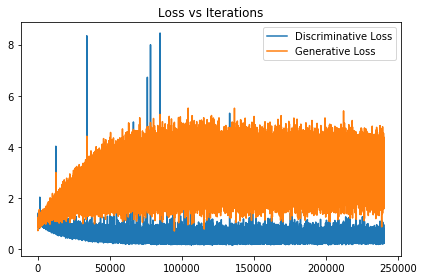

In [14]:
# Plot Graphs
# load()
dloss= train_hist['D_loss'] 
gloss= train_hist['G_loss']
tottime = train_hist['total_time'] 

print('Discriminative Loss:', dloss[-1])
print('Generative Loss:', gloss[-1])
print('Time to run ' + str(epochs)+  ' epochs = ' + str(tottime)+'s')

plt.plot(dloss,label='Discriminative Loss')
plt.plot(gloss, label='Generative Loss')
plt.title('Loss vs Iterations')
plt.legend()
plt.tight_layout()
plt.show()


## Visualizing Outputs from Trained Generative Model

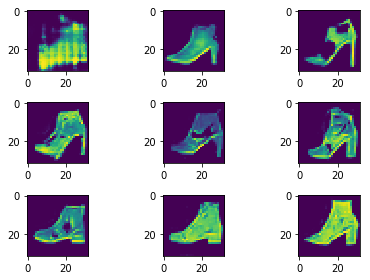

In [21]:
# img[0].shape
k=0
for i in range(9): 
    plt.subplot(3,3, i+1)
    plt.imshow(img[k][3][:,:,0],interpolation='nearest')
    k=k+40
plt.tight_layout()
plt.show()